# Spotify Song Clustering and Playlist Automation

### Project Goal
The goal of this project is to use unsupervised machine learning (K-Means clustering) to segment over 5,000 Spotify songs based on their audio features. By identifying distinct clusters of songs, we can understand the different musical profiles within the dataset, which forms the basis for creating curated and themed playlists automatically.

### Process
1.  **Data Loading and Cleaning:** Import the dataset and clean the column names for easier use.
2.  **Exploratory Data Analysis (EDA):** Investigate the relationships between different audio features to inform our clustering model.
3.  **Data Preprocessing:** Scale the numerical features to ensure that no single feature disproportionately influences the clustering algorithm.
4.  **K-Means Model Training:**
    *   Determine the optimal number of clusters (k) using the Elbow Method and Silhouette Score.
    *   Train the K-Means model with the chosen number of clusters.
5.  **Cluster Analysis & Interpretation:** Analyze the resulting clusters to understand their unique audio characteristics and assign descriptive profiles (e.g., "High-Energy Dance," "Mellow Acoustic").

In [1]:
import pandas as pd

from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import seaborn as sns
import plotly.graph_objects as go
import matplotlib.pyplot as plt

import os


## 1. Data Loading and Cleaning
First, we load the dataset from the CSV file. A preliminary check of the column names reveals trailing spaces, which need to be cleaned for easy access to the data.

In [2]:
spotify_df = pd.read_csv("3_spotify_5000_songs.csv")

# clean column names since they contain a space at the end
songs_df_clean = spotify_df.copy()
songs_df_clean.columns = songs_df_clean.columns.str.strip()
# songs_df_clean.head()


## 2. Exploratory Data Analysis (EDA)

Before clustering, it's important to understand the data. I'll start by exploring the relationships between features. For instance, `tempo` (the speed of the music) and `time_signature` (the number of beats per measure) might be related. A correlation heatmap is a great way to check this.

**Analysis:**
The heatmap below shows a correlation coefficient of nearly zero between `tempo` and `time_signature`. This indicates that there is no significant linear relationship between them, and both can be kept as independent features for our model.

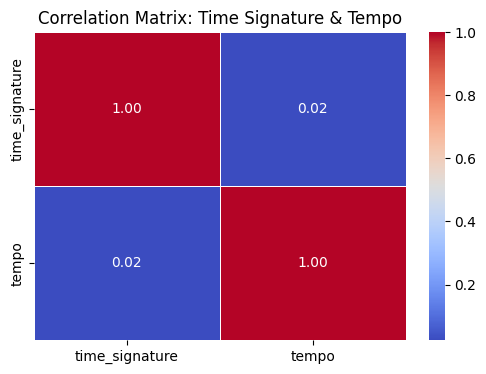

In [3]:
# Calculate correlation matrix for 'time signature' and 'tempo'
correlation_matrix = songs_df_clean[['time_signature', 'tempo']].corr()

# Plot the correlation matrix as a heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix: Time Signature & Tempo")
plt.show()

## 3. Data Preprocessing for Clustering

K-Means is a distance-based algorithm, which means it is sensitive to the scale of the features. To prepare the data for clustering, we'll perform two key steps:

1.  **Feature Selection:** We will select only the relevant audio features for clustering. Non-numeric columns (like `name`, `artist`) and identifier columns (`id`, `html`) will be set aside for later use but excluded from the model. I am also dropping `Unnamed: 0`, `mode`, and `type` as they are not needed for this analysis.

2.  **Normalization:** All numeric audio features will be scaled to a common range (0 to 1) using `MinMaxScaler`. This prevents features with larger ranges (like `loudness` or `tempo`) from dominating the clustering process over features with smaller ranges (like `danceability`).

In [4]:
# Select only the audio features for clustering
audio_features = ['danceability', 'energy', 'key', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms', 'time_signature']

# Keep non-numeric data for later use
song_metadata_df = songs_df_clean.drop(columns=audio_features)

# Create a dataframe with only the numeric features for the model
numeric_features_df = songs_df_clean[audio_features]

    

In [5]:
## Normalization ##
# Create a copy of the dataframe
songs_df_clean_dropped_cols_minmax = numeric_features_df.copy()

# Separate numeric and non-numeric columns
numeric_cols = songs_df_clean_dropped_cols_minmax.select_dtypes(include=['number']).columns
non_numeric_cols = songs_df_clean_dropped_cols_minmax.select_dtypes(exclude=['number']).columns

# Extract the numeric and non-numeric data
numeric_data = songs_df_clean_dropped_cols_minmax[numeric_cols]
non_numeric_data = songs_df_clean_dropped_cols_minmax[non_numeric_cols]

# Initialize the MinMaxScaler
my_min_max = MinMaxScaler().set_output(transform="pandas")

# Normalize only the numeric columns
scaled_features_df = my_min_max.fit_transform(numeric_data)

# Recombine the normalized numeric data with the non-numeric data
minmax_dropped_cols_df = non_numeric_data.join(scaled_features_df)

# Display the final DataFrame
print(minmax_dropped_cols_df.head())


   danceability  energy       key  loudness  speechiness  acousticness  \
0      0.680455  0.2590  1.000000  0.763897     0.076797      0.696787   
1      0.767322  0.3990  0.181818  0.771967     0.037691      0.217871   
2      0.880041  0.7300  0.181818  0.798018     0.377996      0.454819   
3      0.729059  0.0502  0.363636  0.682811     0.051307      0.882530   
4      0.673216  0.1190  0.545455  0.655228     0.041394      0.919679   

   instrumentalness  liveness   valence     tempo  duration_ms  time_signature  
0          0.000060  0.987842  0.310660  0.515800     0.059067             0.8  
1          0.000002  0.108409  0.703553  0.584322     0.042058             0.8  
2          0.000064  0.125633  0.918782  0.437862     0.031590             0.8  
3          0.000041  0.391084  0.531980  0.499098     0.040567             0.8  
4          0.000348  0.105370  0.408122  0.565171     0.063684             0.8  


## 4. Introduction to K-Means Clustering: A 2D Example

Before applying K-Means to the full, multi-dimensional dataset, it's helpful to visualize how the algorithm works in a simple 2D space. This helps build an intuition for what clustering achieves.

I've selected two of the most intuitive features for music: danceability and tempo. The scatter plot below shows each song plotted based on these two features. To demonstrate how K-Means partitions the data, I have applied the algorithm with an illustrative k=80. The red 'X's mark the calculated center (or "centroid") for each cluster.

This plot clearly shows how K-Means groups songs with similar tempo and danceability together. Now, we will apply this same logic to the full set of twelve audio features after first determining the optimal number of clusters to use."

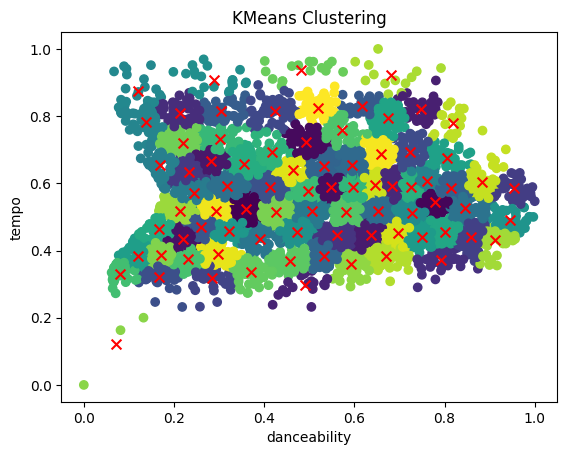

In [6]:
n_cluster = 80
feature_1 = "danceability"
feature_2 = "tempo"
random_seed = 123
two_song_features = minmax_dropped_cols_df.loc[: , [feature_1, feature_2]]


# Initialise the and fit the K-Means model
my_2d_kmeans = KMeans(n_clusters = n_cluster, 
                      random_state = random_seed
                    )
my_2d_kmeans.fit(two_song_features)


# Plot the data points
plt.scatter(x = two_song_features.iloc[:, 0],
            y = two_song_features.iloc[:, 1],
            c = my_2d_kmeans.labels_,
            cmap = 'viridis')


# Plot the centroids
plt.scatter(x = my_2d_kmeans.cluster_centers_[:, 0],
            y = my_2d_kmeans.cluster_centers_[:, 1],
            marker='x',      # Set the marker to 'x'
            s=50,           # Make the markers larger
            color='red')     # Set a distinct color


# Add labels and title
plt.title('KMeans Clustering')
plt.xlabel(two_song_features.columns[0])
plt.ylabel(two_song_features.columns[1])

# Display the plot
plt.show()

## 5. Determining the Optimal Number of Clusters (k)

To find the best number of playlists (clusters) to create, I used two common techniques:

1.  **The Elbow Method:** This method looks for the "elbow" point in the plot of inertia (within-cluster sum of squares) vs. the number of clusters. The elbow represents the point where adding more clusters doesn't significantly reduce inertia.
2.  **Silhouette Score:** This score measures how similar a song is to its own cluster compared to other clusters. A higher score indicates better-defined clusters.

**Analysis of Plots:**
*   The **Inertia Plot** shows a significant "elbow" around k=15, after which the drop in inertia slows down considerably.
*   The **Silhouette Score Plot** shows its highest peaks between k=2 and k=10, with a general decline afterward.

**Conclusion on 'k':**
While a smaller `k` (like 10) is technically optimal according to the metrics, the goal is to create a diverse set of playlists. For this prototype, I chose **k=50** to generate more granular and specific musical moods, accepting that some clusters might be less distinct than others. This allows for a wider variety of potential playlists to be explored.

In [7]:
### USE ELBOW METHOD

# Separate numeric and non-numeric columns
numeric_cols = minmax_dropped_cols_df.select_dtypes(include=['number']).columns
non_numeric_cols = minmax_dropped_cols_df.select_dtypes(exclude=['number']).columns

# Extract the numeric and non-numeric data
numeric_data = minmax_dropped_cols_df[numeric_cols]
non_numeric_data = minmax_dropped_cols_df[non_numeric_cols]


# Decide on a random_state to use
seed = 123

# Set the maximum number of clusters to try
max_k = 100

# Create an empty list to store the inertia scores
inertia_list = []

# Iterate over the range of cluster numbers
for i in range(1, max_k + 1):

    # Create a KMeans object with the specified number of clusters
    myKMeans = KMeans(n_clusters = i,
                      n_init = "auto",
                      random_state = seed
                      )

    # Fit the KMeans model to the scaled data
    myKMeans.fit(numeric_data)

    # Append the inertia score to the list
    inertia_list.append(myKMeans.inertia_)

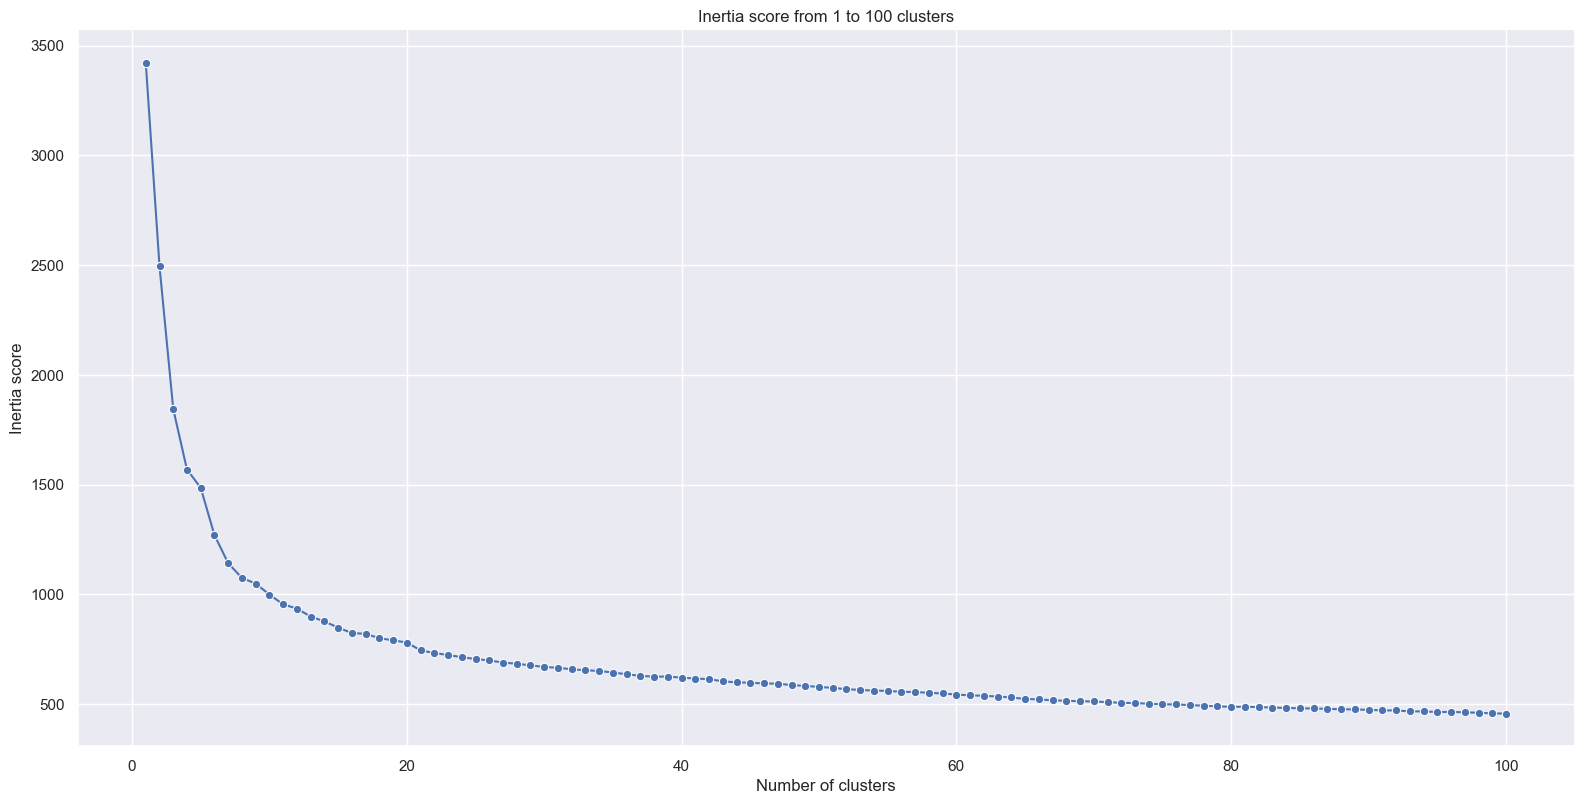

In [8]:
sns.set_theme(style='darkgrid')

(
# Create a line plot of the inertia scores
sns.relplot(y = inertia_list,
            x = range(1, max_k + 1),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
# Set the title of the plot
.set(title=f"Inertia score from 1 to {max_k} clusters")
# Set the axis labels
.set_axis_labels("Number of clusters", "Inertia score")
);

In [9]:
#### SILHOUETTE SCORE
# Set the maximum number of clusters to try
max_k = 100

# Create an empty list to store the silhouette scores
sil_scores = []


for j in range(2, max_k+1):

    # Create a KMeans object with the specified number of clusters
    kmeans = KMeans(n_clusters = j,
                    n_init = "auto",
                    random_state = seed)

    # Fit the KMeans model to the scaled data
    kmeans.fit(numeric_data)

    # Get the cluster labels
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(numeric_data, labels)

    # Append the silhouette score to the list
    sil_scores.append(score)

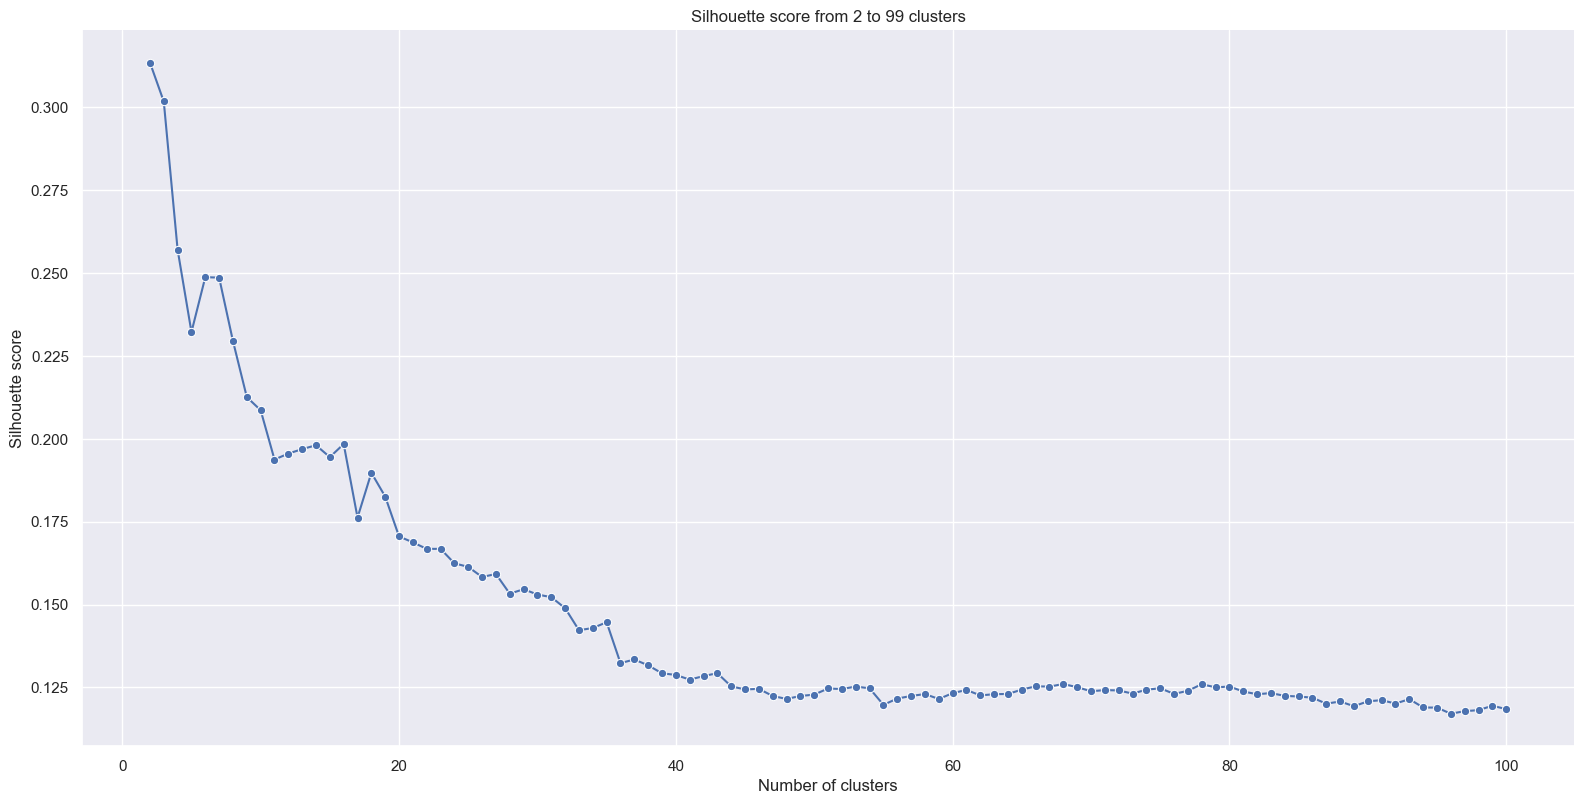

In [10]:
(
sns.relplot(y = sil_scores,
            x = range(2, max_k+1),
            kind = 'line',
            marker = 'o',
            height = 8,
            aspect = 2)
.set(title=f"Silhouette score from 2 to {max_k - 1} clusters")
.set_axis_labels("Number of clusters", "Silhouette score")
);

## 6. Applying K-Means and Profiling the Clusters

With k=50, the K-Means algorithm was applied to the scaled audio features. Each of the 5,000+ songs is now assigned to one of 50 clusters.

To understand the character of each cluster, I created a radar chart visualizing the mean audio feature values for each group. This helps us create a "personality profile" for every playlist.

In [11]:
numeric_data_df = numeric_data.copy()
# Initialise the model
my_kmeans = KMeans(n_clusters = n_cluster, # you always choose the number of k here
                   random_state = random_seed)

# Fit the model to the data
my_kmeans.fit(numeric_data_df)

# Obtain the cluster output
clusters = my_kmeans.labels_

# Attach the cluster output to our original DataFrame
numeric_data_df["cluster"] = clusters
print(numeric_data_df["cluster"].value_counts().head(10))

cluster
16    154
7     154
55    120
32    118
1     116
28    115
9     114
49    111
45    109
26    109
Name: count, dtype: int64


In [12]:
# Create an empty list to store the Scatterpolar object of each cluster
scatter_objects = []

scaled_features_df = numeric_data_df.copy()

# State the label for each arm of the chart
categories = scaled_features_df.columns

# Iterate over the unique clusters and add an object for each cluster to the list
for cluster in sorted(scaled_features_df['cluster'].unique()):

  # Find the mean value for each column of the cluster
  cluster_means = [scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[0]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[1]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[2]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[3]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[4]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[5]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[6]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[7]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[8]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[9]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[10]].mean(),
                  scaled_features_df.loc[scaled_features_df["cluster"] == cluster, scaled_features_df.columns[11]].mean()]
                  # Bonus: see if you can turn this code for `cluster_means` into a list comprehension

  # Create a Scatterpolar object for the cluster
  cluster_scatter = go.Scatterpolar(
    r = cluster_means, # set the radial coordinates
    theta = categories, # the names of the columns
    fill = 'toself', # fills in the space with colour
    name = f'Cluster {cluster}' # adds the name of the cluster
  )

  # Add the Scatterpolar object to the list
  scatter_objects.append(cluster_scatter)

# Create the figure (the white area)
fig = go.Figure()

# Add the scatter objects to the figure
fig.add_traces(scatter_objects)

# Add extras to the plot, such as title
fig.update_layout(
  title_text = 'Radar chart of mean preferences by cluster',
  height = 600,
  width = 800,
  polar = dict(
    radialaxis = dict(
      visible = True, # visibility of the numbers on the arm
      range = [0, 1] # scale of the plot
    )),
  showlegend = True,
  paper_bgcolor='#000000',
  plot_bgcolor='#000000',
  font=dict(color='#00cf61')
)

# Show the initialised plot and the trace objects
fig.show()

![Radar chart showing mean audio features for each song cluster](radar_chart_plot.png)

### Cluster Profile Analysis

The radar chart reveals the distinct sonic characteristics of each cluster. For example:

*   **Cluster 4 (High Energy, Low Acousticness):** This cluster has very high `energy` and `loudness` but extremely low `acousticness`. This is a perfect profile for an intense workout or "Hype" playlist.
*   **Cluster 28 (Low Energy, High Acousticness):** In contrast, this cluster shows low `energy`, low `loudness`, and very high `acousticness` and `instrumentalness`. This suggests a collection of calm, acoustic, or classical tracks suitable for a "Focus" or "Chill" playlist.
*   **Cluster 0 (High Danceability & Valence):** This cluster scores high on `danceability` and `valence` (positivity), making it ideal for a feel-good, party playlist.

By examining these profiles, we can thematically label each cluster and use them as ready-made playlists.

## 7. Conclusion and Next Steps

### Conclusion
This project successfully demonstrated the use of K-Means clustering to segment a diverse dataset of Spotify songs into 50 distinct musical profiles. By cleaning the data, applying appropriate preprocessing, and analyzing cluster characteristics through visualizations like radar charts, we have created a prototype for an automated playlist generation system. The resulting clusters are well-defined by their audio features, allowing for thematic interpretation and direct use as curated playlists.

### Possible Next Steps
*   **Playlist Generation Function:** Build a Python function that takes a cluster ID as input and returns a list of song names and artists, or even creates a playlist directly using the Spotify API.
*   **Qualitative Feature Integration:** Incorporate genre information or other qualitative tags to further enrich the playlist themes.
*   **Alternative Clustering Models:** Experiment with other algorithms like DBSCAN or Hierarchical Clustering to see if they produce more meaningful clusters.
*   **Interactive Dashboard:** Build a simple dashboard (e.g., with Streamlit or Dash) to allow users to explore the different cluster profiles and view the songs within them.

## 8. Appendix
### Feaute Importance


In [13]:

# Calculate the mean value of each feature for each cluster using the main dataframe
cluster_means = numeric_data_df.groupby('cluster').mean()

# Compute the standard deviation of each feature across clusters
# This shows which features vary the most and are therefore most "important" for clustering
feature_importance = cluster_means.std().sort_values(ascending=False)

# Display the most important features
print(feature_importance)

instrumentalness    0.377674
acousticness        0.374193
key                 0.293791
energy              0.289848
valence             0.260027
danceability        0.189218
liveness            0.166376
loudness            0.095427
time_signature      0.094537
tempo               0.077535
speechiness         0.034832
duration_ms         0.022741
dtype: float64


In [14]:
# Compute the standard deviation of each feature across clusters
feature_importance = cluster_means.std().sort_values(ascending=False)
print(feature_importance)


instrumentalness    0.377674
acousticness        0.374193
key                 0.293791
energy              0.289848
valence             0.260027
danceability        0.189218
liveness            0.166376
loudness            0.095427
time_signature      0.094537
tempo               0.077535
speechiness         0.034832
duration_ms         0.022741
dtype: float64


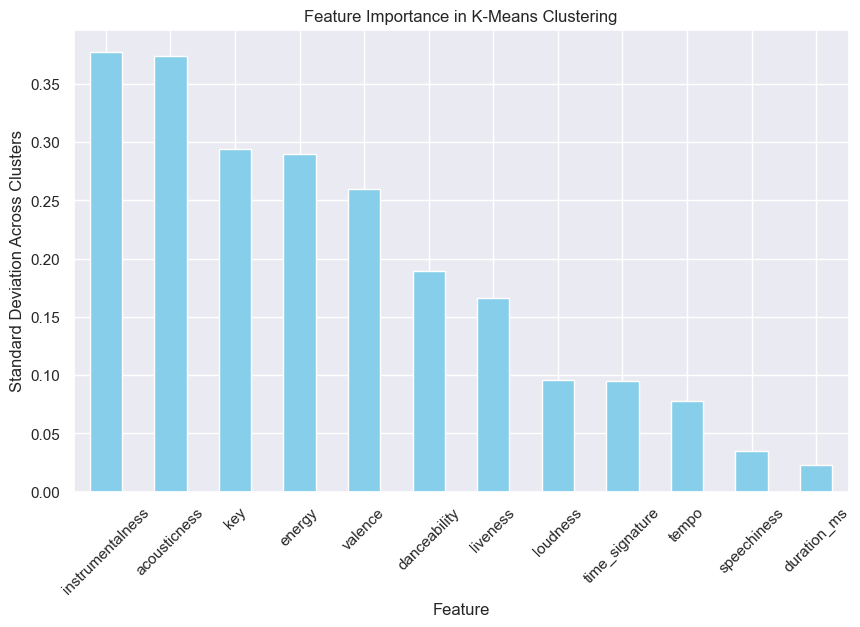

In [15]:
# Plot feature importance (standard deviation across clusters)
plt.figure(figsize=(10, 6))
feature_importance.plot(kind='bar', color='skyblue')
plt.title('Feature Importance in K-Means Clustering')
plt.xlabel('Feature')
plt.ylabel('Standard Deviation Across Clusters')
plt.xticks(rotation=45)
plt.show()


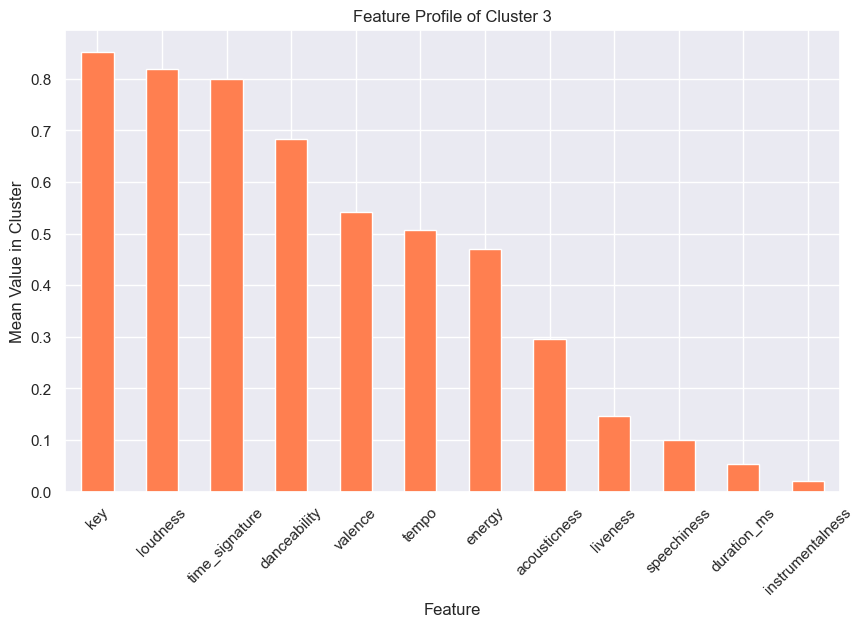

In [16]:
# Get the feature means for Cluster 3
cluster_3_profile = cluster_means.loc[3]


# cluster_3_profile.drop('cluster', inplace=True)



# Sort features to see which ones stand out most
cluster_3_profile_sorted = cluster_3_profile.sort_values(ascending=False)


# Plot the feature profile for Cluster 3
plt.figure(figsize=(10, 6))
cluster_3_profile_sorted.plot(kind='bar', color='coral')
plt.title('Feature Profile of Cluster 3')
plt.xlabel('Feature')
plt.ylabel('Mean Value in Cluster')
plt.xticks(rotation=45)
plt.show()
